In [1]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [6]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [7]:
target_days = 10
cross = False
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [8]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [9]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
"""
param_grid_NN = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [50],  
    'batch_size': [32, 64]
}
#param_grid_NN =  {'batch_size': [64], 'epochs': [50], 'optimizer': ['rmsprop']}

#NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)



param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}
#param_grid_alpha = {'alpha': [1.0]}
#ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha, cross)


param_grid_lgb = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127, 255]
}


#lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)


In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step
Ridge Classifier:
Accuracy: 0.5615402387370042
Confusion Matrix:
[[  2347  83537]
 [  1864 107027]]
Precision: 56.163283726202216
Recall: 98.28819645333407
F1 Score: 71.48119083000785
MSE: 43.845976126299576
RMSE: 66.21629416261497


LightGBM Classifier:
Accuracy: 0.5590604543704274
Confusion Matrix:
[[     0  85884]
 [     0 108891]]
Precision: 55.90604543704274
Recall: 100.0
F1 Score: 71.717610796072
MSE: 44.09395456295726
RMSE: 66.40327895741088


Neural Network:
Accuracy: 0.5294724682325761
Confusion Matrix:
[[24355 61529]
 [30118 78773]]
Precision: 56.14531510598566
Recall: 72.34114848793747
F1 Score: 63.22248217245268
MSE: 47.05275317674239
RMSE: 68.59500942251003




In [10]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [11]:
results_best = {}
results_worst = {}
models = {
#    'lgb': lgb_best,
#    'ridge': ridge_best,
#    'NN': NN_model,
    'benchmark': None
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}


In [12]:
%reload_ext autoreload
%autoreload 2

signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)


In [17]:
portfolio_bench = portfolio_dfs['benchmark']
#pickle signal_bench

pickle.dump(portfolio_bench, open('portfolio_bench.pickle', 'wb'))

In [18]:
len(portfolio_bench)

3359

In [13]:
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']
benchmark_weights = portfolio_dfs['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read



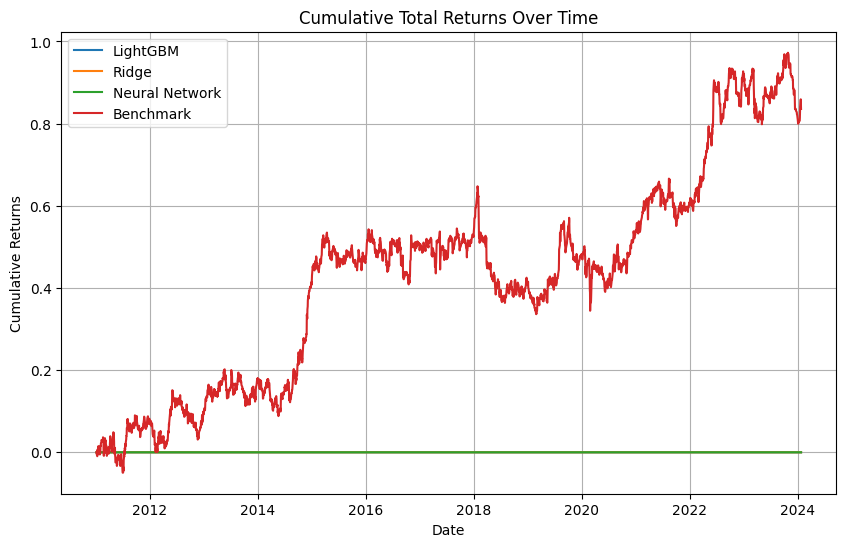

In [14]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [34]:
%reload_ext autoreload
%autoreload 2
ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [35]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Yearly Sharpe Ratio,Max Drawdown,Yearly Volatility,Calmar Ratio,Skewness,Kurtosis,Yearly Trades,Yearly Turnover,Yearly Transaction Costs
Ridge,0.021495,0.107869,0.199271,-0.292206,0.107869,0.073562,-0.212763,2.684846,564.642857,79.077929,0.007908
LightGBM,-0.012768,0.137425,-0.092912,-0.455122,0.137425,-0.028055,-4.673997,106.231024,532.785714,67.973805,0.006797
Neural Network,-0.020848,0.109327,-0.190694,-0.488974,0.109327,-0.042636,-0.385791,4.571321,570.285714,125.294445,0.012529
Benchmark,0.037401,0.116378,0.321378,-0.335693,0.116378,0.111415,-0.989208,8.987494,486.357143,33.309696,0.003331


In [36]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



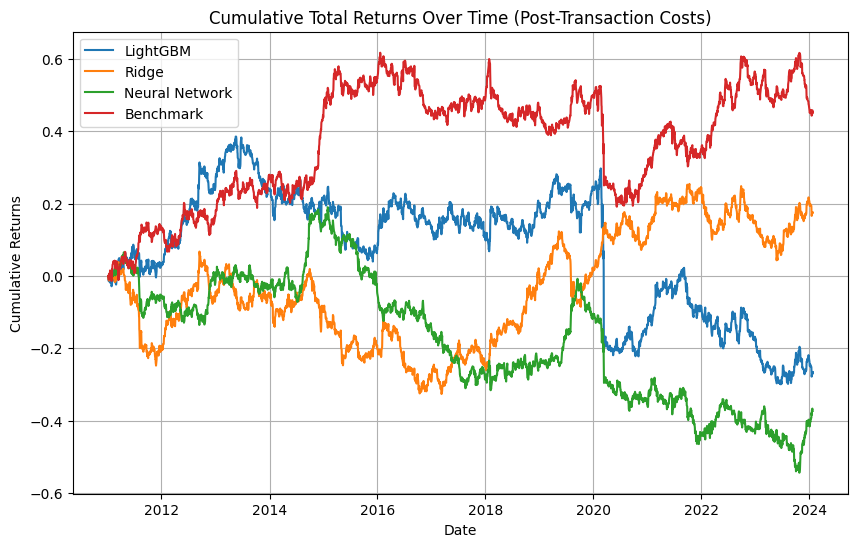

In [37]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

